In [62]:
USE_EVENT_DATA = True

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage import gaussian_filter
from scipy.stats import bootstrap
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import os
import pathlib
import warnings
import json

# from metrics import *
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen

if not USE_EVENT_DATA:
  from utils import *
  from plot_utils import *
  init_notebook_mode(connected=True)

warnings.filterwarnings('ignore')
%matplotlib inline

In [31]:
train = None
if not USE_EVENT_DATA:
  master.to_csv('Soccer_Event_Data.csv')
  train = master.copy()
else:
  train = pd.read_csv('Soccer_Event_Data.csv',index_col=0)

shots = train.loc[train['subEventName'] == 'Shot']
if USE_EVENT_DATA:
  shots.positions = shots.positions.str.replace("'", '"').apply(json.loads)
  shots.tags = shots.tags.str.replace("'", '"').apply(json.loads)

# get shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
# calculate distance and angle 
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
# if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object 
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
shots["D2"] = shots["Distance"]**2
shots["Angle2"] = shots["Angle"] * 180 / np.pi
goals = shots.loc[shots["Goal"] == 1]

# X and Y distributions

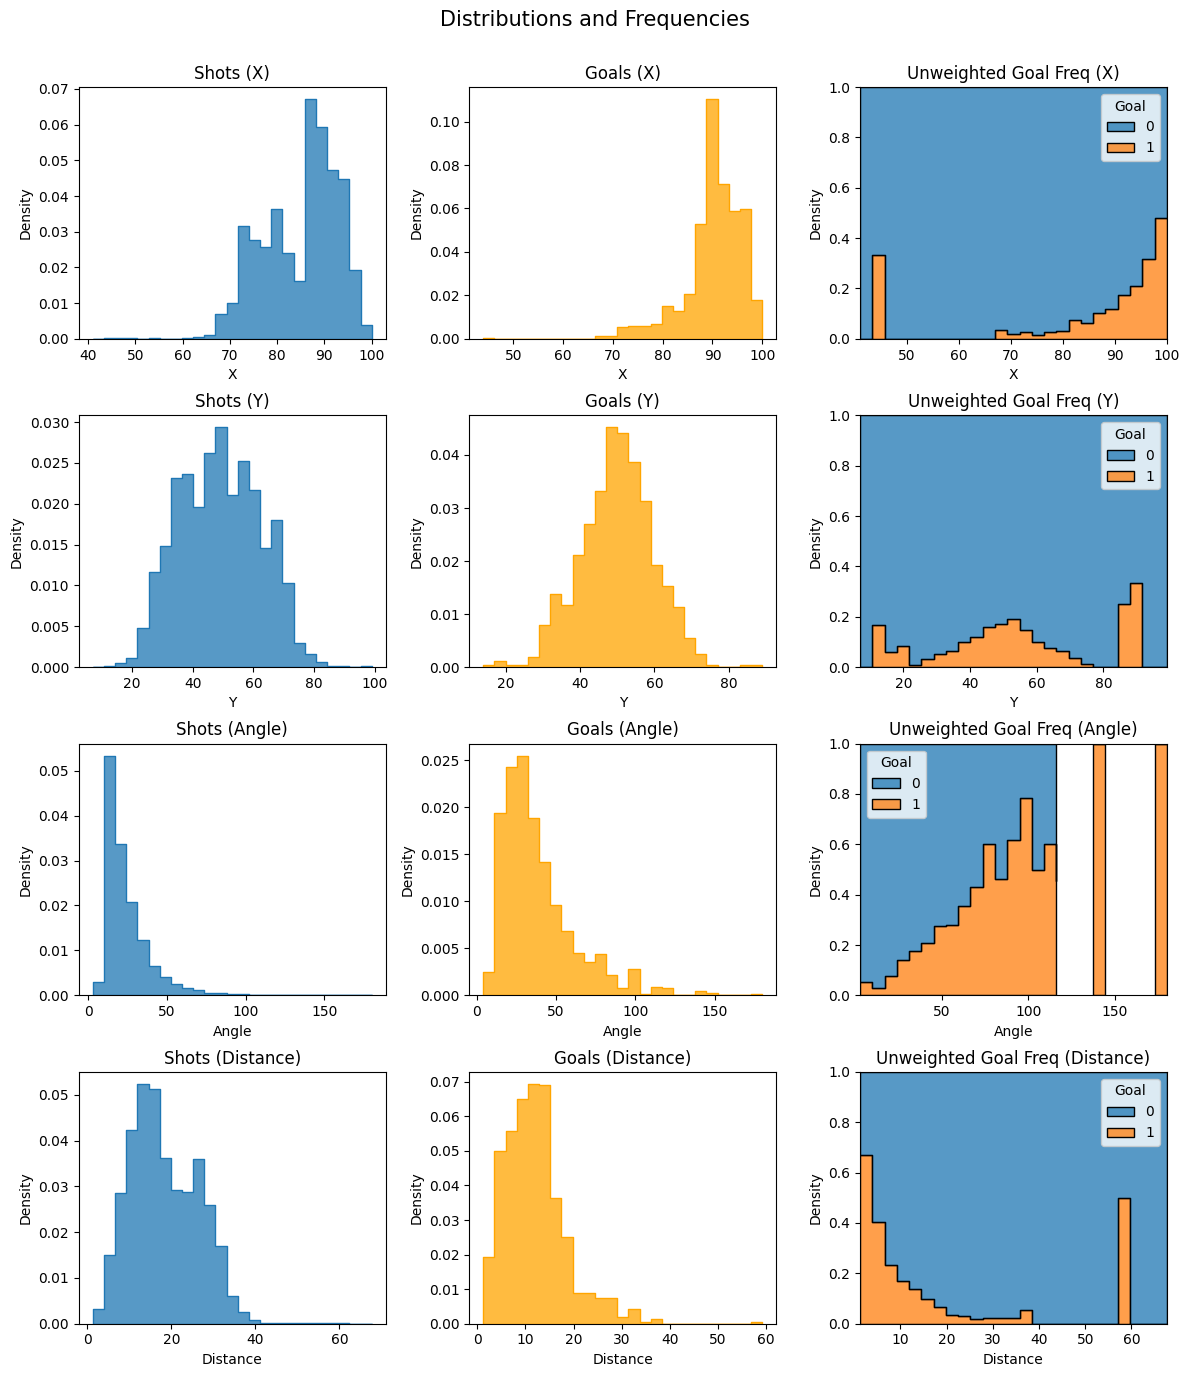

In [32]:
_vars = ["x", "y", "Angle2", "Distance"]
labels = ["X", "Y", "Angle", "Distance"]

fig, axes = plt.subplots(4, 3, figsize=(12, 14))
for i in range(4):
  sns.histplot(ax=axes[i,0], x=shots[_vars[i]], bins=25, stat="density", element="step")
  sns.histplot(ax=axes[i,1], x=goals[_vars[i]], color="orange", bins=25, stat="density", element="step")
  sns.histplot(x=shots[_vars[i]], hue=shots["Goal"], bins=25, ax=axes[i, 2], element="step", stat="density", multiple="fill")
  axes[i, 0].set_xlabel(labels[i])
  axes[i, 1].set_xlabel(labels[i])
  axes[i, 2].set_xlabel(labels[i])
  axes[i, 0].set_title(f"Shots ({labels[i]})")
  axes[i, 1].set_title(f"Goals ({labels[i]})")
  axes[i, 2].set_title(f"Unweighted Goal Freq ({labels[i]})")

plt.tight_layout()
fig.subplots_adjust(top=0.925)
fig.suptitle("Distributions and Frequencies", fontsize=15)
plt.show()

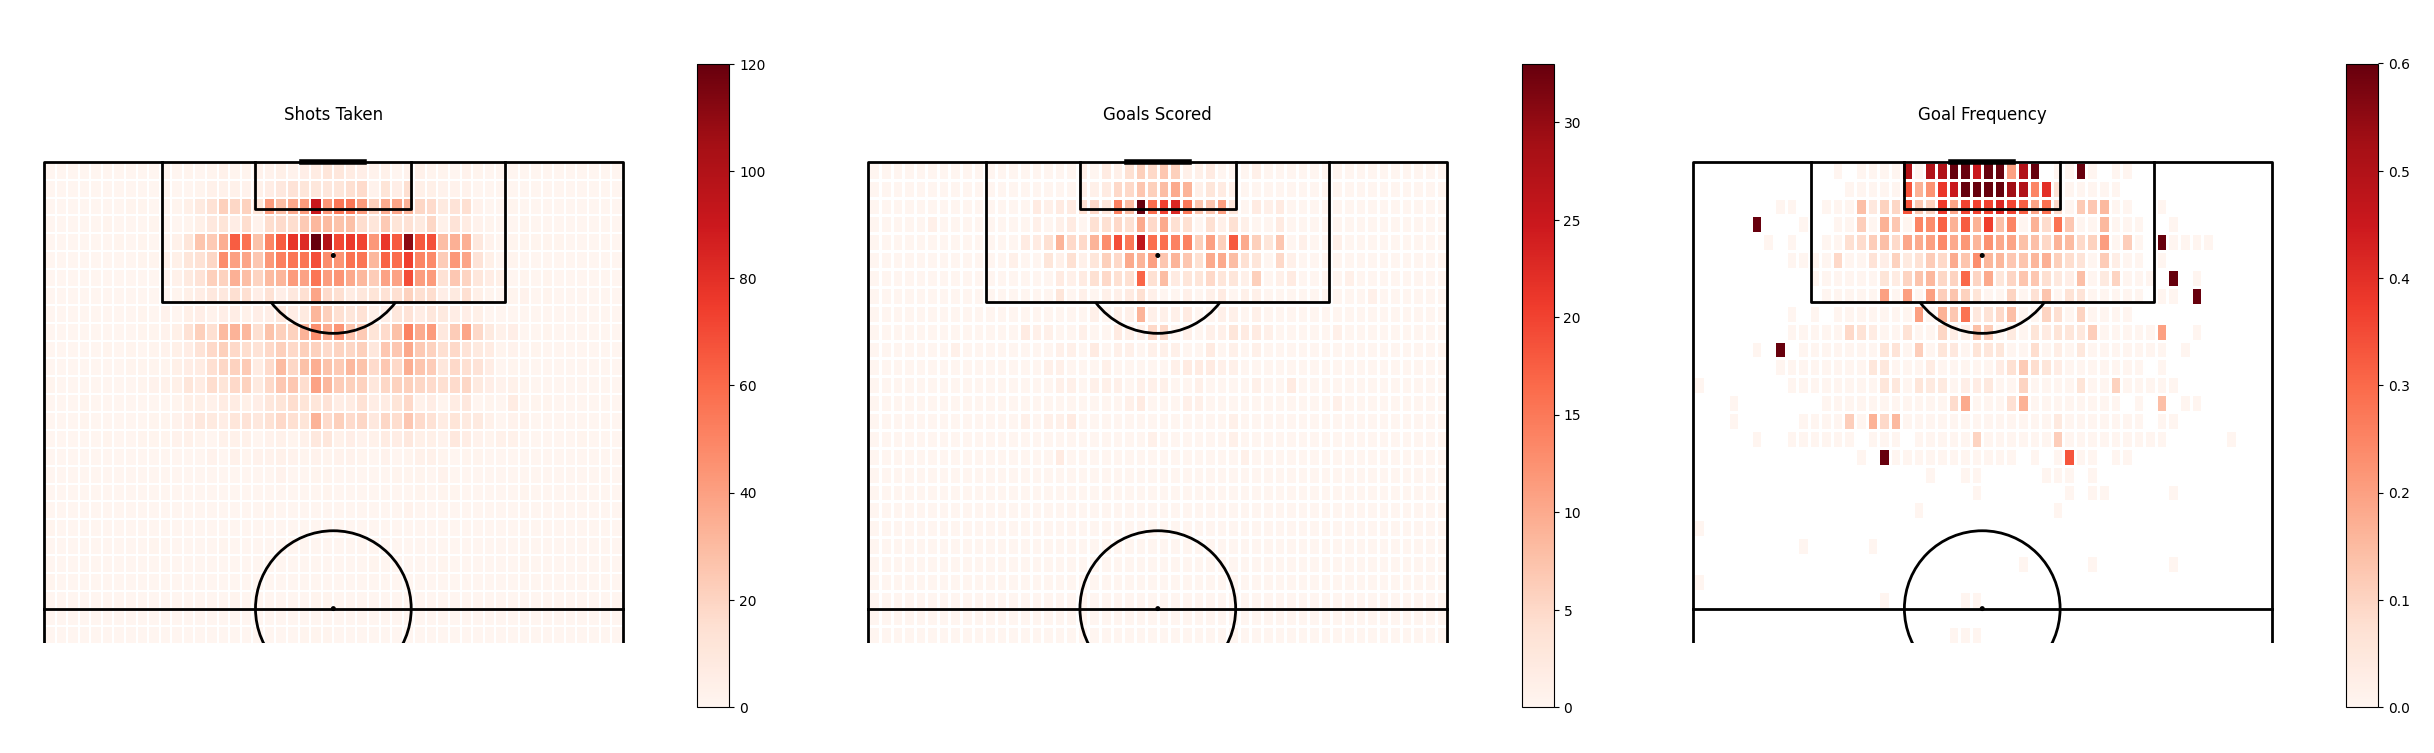

In [33]:
goals = shots.loc[shots["Goal"] == 1]

pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, axes = pitch.grid(ncols=3,title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_stat_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)
bin_stat_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)
bin_stat_probs = bin_stat_shots.copy()
bin_stat_probs['statistic'] = bin_stat_goals['statistic'] / bin_stat_shots['statistic']

pcm1 = pitch.heatmap(bin_stat_shots, ax=axes['pitch'][0], cmap='Reds', edgecolor='white', linewidth=0.01)
pcm2 = pitch.heatmap(bin_stat_goals, ax=axes['pitch'][1], cmap='Reds', edgecolor='white')
pcm3 = pitch.heatmap(bin_stat_probs, ax=axes['pitch'][2], cmap='Reds', edgecolor='white', vmin=0, vmax=0.6)

axes['pitch'][0].set_title('Shots Taken')
axes['pitch'][1].set_title('Goals Scored')
axes['pitch'][2].set_title('Goal Frequency')

fig.colorbar(pcm1, ax=axes['pitch'][0])
fig.colorbar(pcm2, ax=axes['pitch'][1])
fig.colorbar(pcm3, ax=axes['pitch'][2])
plt.show()

# Swaths

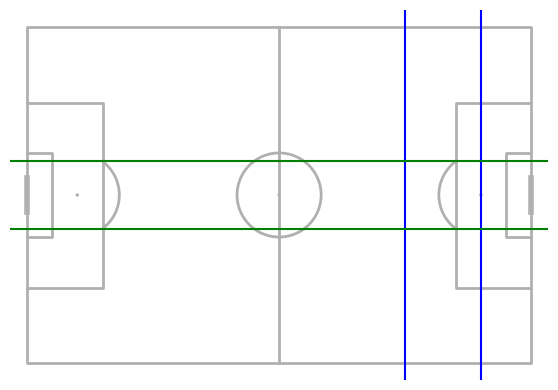

In [34]:
pitch = Pitch()
fig, ax = pitch.draw(figsize=(8,4))
# scaled xmax: 120, ymax: 80
ax.axvline(75*120/100, c='b')
ax.axvline(90*120/100, c='b')
ax.axhline(40*80/100, c='g')
ax.axhline(60*80/100, c='g')
plt.show()

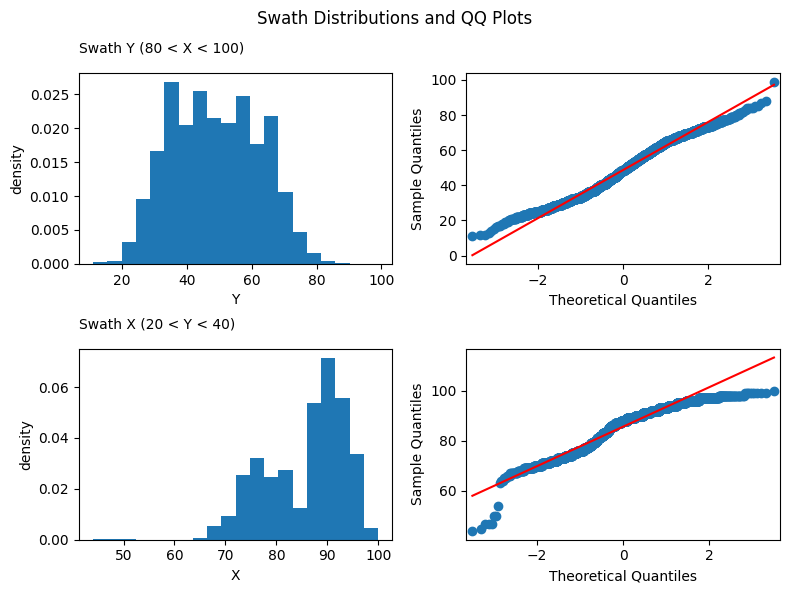

In [35]:
swathy = shots[shots['x'].between(75, 90)]
swathx = shots[shots['y'].between(40, 60)]
swaths = [swathy.y, swathx.x]
xlabels = ["Y", "X"]
labels = ["Swath Y (80 < X < 100)", "Swath X (20 < Y < 40)"]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i in range(2):
  axes[i, 0].hist(swaths[i], density=True, bins=20, linewidth=2)
  axes[i, 0].set_xlabel(xlabels[i])
  axes[i, 0].set_ylabel("density")
  axes[i, 0].set_title(labels[i], loc="left", fontsize=10, pad=15)
  sm.qqplot(data=swaths[i], ax=axes[i, 1], line='s')
plt.tight_layout()
fig.subplots_adjust(top=0.875)
fig.suptitle("Swath Distributions and QQ Plots")
plt.show()

In [36]:
features = {
  "goal freq": shots['Goal'].astype(np.float32),
  "total x": shots.x,
  "total y": shots.y,
  "total angle": shots['Angle2'],
  "total distance": shots['Distance'],
  "swath x": swathx.x,
  "swath y": swathy.y,
}

stats = {
  "mean": np.mean,
  "std": np.std,
}

for stat, func in stats.items():
  print(f"CONFIDENCE INTERVALS FOR {stat.upper()}")
  for feature, data in features.items():
    res = bootstrap((data.to_numpy(),), func, confidence_level=0.95)
    conf = res.confidence_interval
    print(f"{feature}:\t{conf.low:02.5f},\t{conf.high:02.5f}")

CONFIDENCE INTERVALS FOR MEAN
goal freq:	0.10164,	0.11478
total x:	84.77126,	85.10630
total y:	48.58997,	49.16119
total angle:	23.98943,	24.61869
total distance:	18.11442,	18.45512
swath x:	85.44765,	85.91592
swath y:	48.34506,	49.08937
CONFIDENCE INTERVALS FOR STD
goal freq:	0.30202,	0.31890
total x:	7.67053,	7.90285
total y:	13.09425,	13.42337
total angle:	14.50516,	15.64799
total distance:	7.90958,	8.15865
swath x:	7.72437,	8.06065
swath y:	13.47930,	13.88262


# PLOT SHOTS


## Investigating the relationship between goals and angle
We want to find out if the angle influences scoring a goal. First we plot if goal was scored given
the angle.



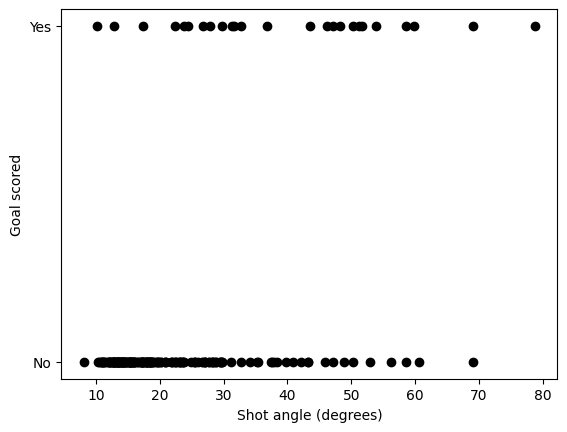

In [37]:
#first 200 shots
shots_200=shots.iloc[:200]
#plot first 200 shots goal angle
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

## Investigating the relationship between probability of scoring goals and angle
We want to find out if the angle influences the probability of scoring a goal. First we plot if goal was scored given
the angle.



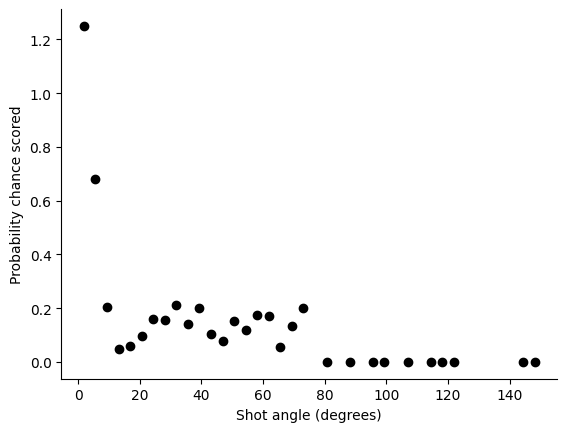

In [38]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2
#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitting logistic regression with random coefficients
To our data we fit a logistic regression curve with set parameters - 3 for intercept and -3 for angle. However, these are most likely
not the best estimators of true parameters. 



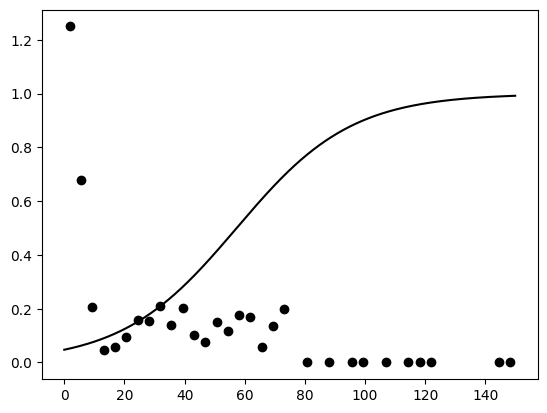

In [39]:
fig, ax = plt.subplots()
b = [3, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
#plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

## Calculating log-likelihood
The best parameters are those which maximize the log-likelihood.



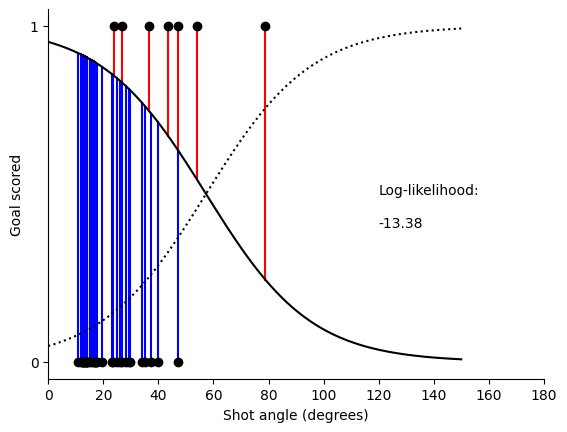

In [40]:
#calculate xG
xG = 1/(1+np.exp(b[0]+b[1]*shots['Angle'])) 
shots = shots.assign(xG = xG)
shots_40 = shots.iloc[:40]
fig, ax = plt.subplots()
#plot data
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markersize= 12, color='black', zorder = 3)
#plot curves
ax.plot(x, y, linestyle=':', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)
#calculate loglikelihood
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang = shot['Angle'] * 180/np.pi
    if shot['Goal'] == 1:
        loglikelihood = loglikelihood + np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='red', zorder = 1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG'])
        ax.plot([ang,ang], [shot['Goal'], 1-shot['xG']], color='blue', zorder = 1) 
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,180))
plt.text(120,0.5,'Log-likelihood:') 
plt.text(120,0.4,str(loglikelihood)[:6])
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitting logistic regression and finding best parameters
The best parameters are those which maximize the log-likelihood.



                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2561.2
Date:                    Fri, 13 Dec 2024   Deviance:                       5122.5
Time:                            20:18:29   Pearson chi2:                 7.96e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07609
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

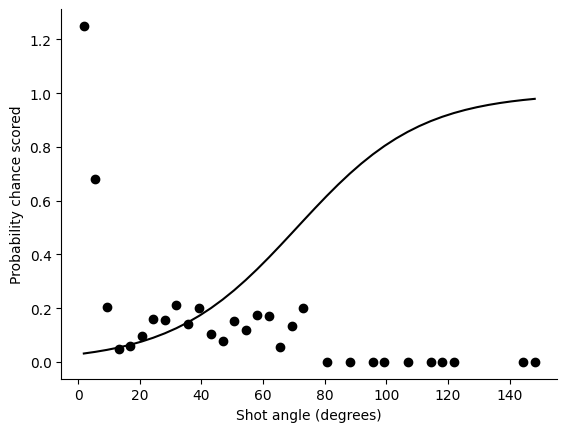

In [41]:
#create model
test_model = smf.glm(formula="Goal ~ Angle" , data=shots, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())
#get params        
b=test_model.params
#calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig, ax = plt.subplots()
#plot data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot line
ax.plot(midangle, xGprob, linestyle='solid', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Investigating the relationship between probability of scoring goals and distance to goal 
We want to find out if the distanse influences the probability of scoring a goal. First we plot the probability of scoring given
the distance. Then, we fit logistic regression to the data.



                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2524.4
Date:                    Fri, 13 Dec 2024   Deviance:                       5048.9
Time:                            20:18:29   Pearson chi2:                 1.56e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08410
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

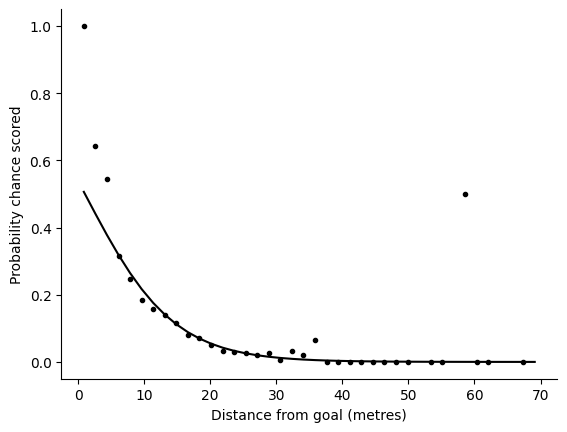

In [42]:
#number of shots
shotcount_dist = np.histogram(shots['Distance'],bins=40,range=[0, 70])
#number of goals
goalcount_dist = np.histogram(goals['Distance'],bins=40,range=[0, 70])
#empirical probability of scoring
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
#making a plot
fig, ax = plt.subplots()
#plotting data
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots, 
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())        
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
#plot line
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

## Adding squared distance to the model



                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8448
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2505.6
Date:                    Fri, 13 Dec 2024   Deviance:                       5011.1
Time:                            20:18:29   Pearson chi2:                 8.44e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08818
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

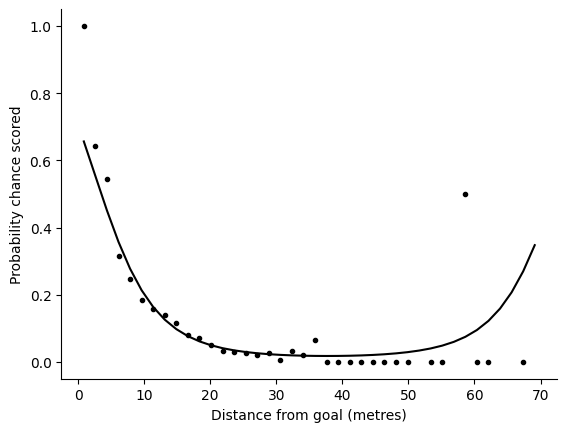

In [43]:
#adding it to the model
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots, 
                           family=sm.families.Binomial()).fit()
#print model summary
print(test_model.summary()) 
#get parameters       
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig, ax = plt.subplots()
#plot line
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8448
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2501.6
Date:                    Fri, 13 Dec 2024   Deviance:                       5003.2
Time:                            21:01:07   Pearson chi2:                 9.42e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08904
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

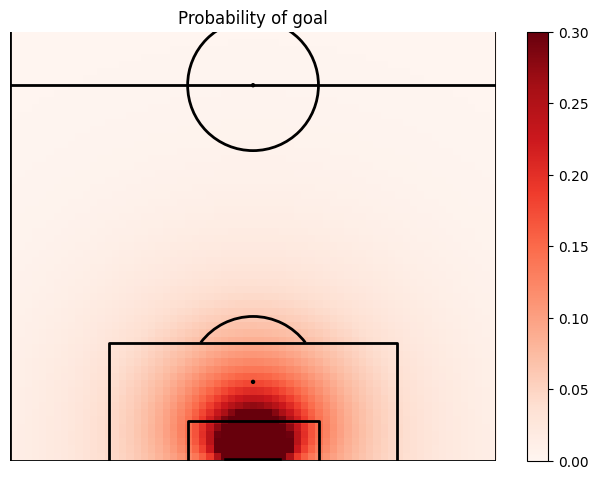

In [71]:
model_variables = ["Angle", "Distance"]
test_model = smf.glm(formula="Goal ~ Angle + Distance", data=shots, 
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())        
b=test_model.params

#return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

#add an xG to my dataframe
xG=shots.apply(calculate_xG, axis=1) 
shots = shots.assign(xG=xG)

#Create a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['X'] = x
        
        pgoal_2d[x,y] =  calculate_xG(sh)

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)
#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Testing model fit


-ROC curve.



TESTING Goal ~ 1
McFadden R^2 = 0.0000
AUC: 0.5000
                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8450
Model Family:                    Binomial   Df Model:                            0
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2895.6
Date:                    Fri, 13 Dec 2024   Deviance:                       5791.2
Time:                            20:49:31   Pearson chi2:                 8.45e+03
No. Iterations:                         5   Pseudo R-squ. (CS):         -2.220e-16
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

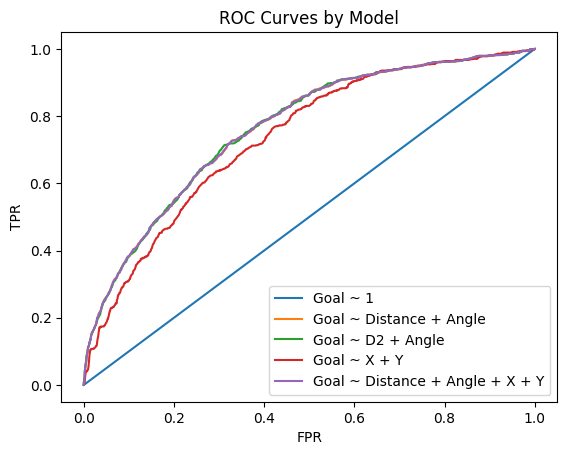

In [70]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots, family=sm.families.Binomial()).fit()

formulas = [
  "Goal ~ 1",
  "Goal ~ Distance + Angle",
  "Goal ~ D2 + Angle",
  "Goal ~ X + Y",
  "Goal ~ Distance + Angle + X + Y"
]

y_true = shots["Goal"].to_numpy().astype(np.int32)
for formula in formulas:
  model = smf.glm(formula=formula, data=shots, family=sm.families.Binomial())
  model = model.fit()
  y_pred = 1 - model.predict(shots)
  print(f"TESTING {formula}")
  print(f"McFadden R^2 = {1 - model.llf / null_model.llf:0.4f}")
  print(f"AUC: {roc_auc_score(y_true, y_pred):0.4f}")
  print(model.summary())
  fprs, tprs, _ = roc_curve(y_true, y_pred)
  plt.plot(fprs, tprs, label=formula)
plt.title("ROC Curves by Model")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=0)
plt.show()